In [21]:

import os
os.environ["OMP_NUM_THREADS"] = "1"
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load data
df = pd.read_csv("Food_Delivery_Time_Prediction.csv")

# Drop ID
df = df.drop(columns=['Order_ID'])

# Encode categorical variables
categorical_cols = ['Customer_Location', 'Restaurant_Location', 'Weather_Conditions',
                    'Traffic_Conditions', 'Order_Priority', 'Vehicle_Type']
df[categorical_cols] = df[categorical_cols].apply(LabelEncoder().fit_transform)

# Convert order time to rush hour
df['Rush_Hour'] = df['Order_Time'].apply(lambda x: 1 if '11:' in x or '18:' in x else 0)
df.drop(columns=['Order_Time'], inplace=True)

# Binary target variable
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 0 if x <= 45 else 1)
df.drop(columns=['Delivery_Time'], inplace=True)

df.head()


,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Vehicle_Type,Restaurant_Rating,Customer_Rating,Order_Cost,Tip_Amount,Rush_Hour,Delivery_Status
0,98,10,1.57,1,2,4,2,2,4.1,3.0,1321.10,81.54,0,0
1,73,50,21.32,0,2,8,1,2,4.5,4.2,152.21,29.02,0,1
2,79,163,6.95,2,2,9,0,1,3.3,3.4,1644.38,64.17,0,1
3,160,107,13.79,0,1,2,2,1,3.2,3.7,541.25,79.23,0,1
4,65,71,6.72,1,0,6,1,1,3.5,2.8,619.81,2.34,0,0


C:\Users\devma\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devma\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devma\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\devma\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_

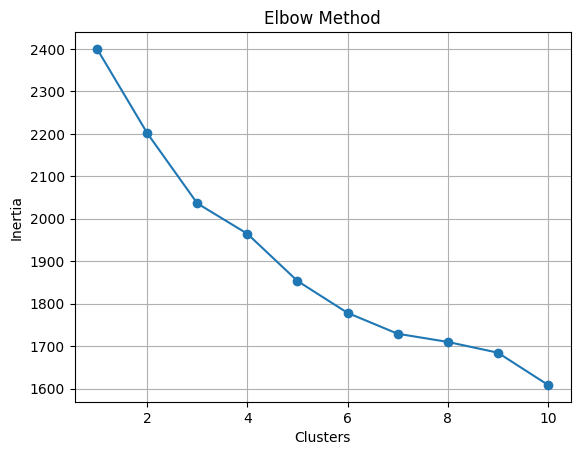

C:\Users\devma\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


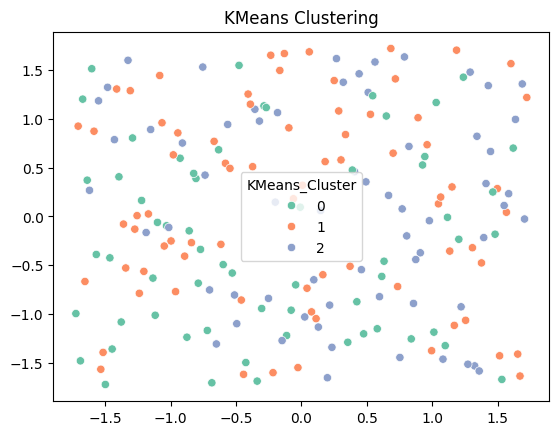

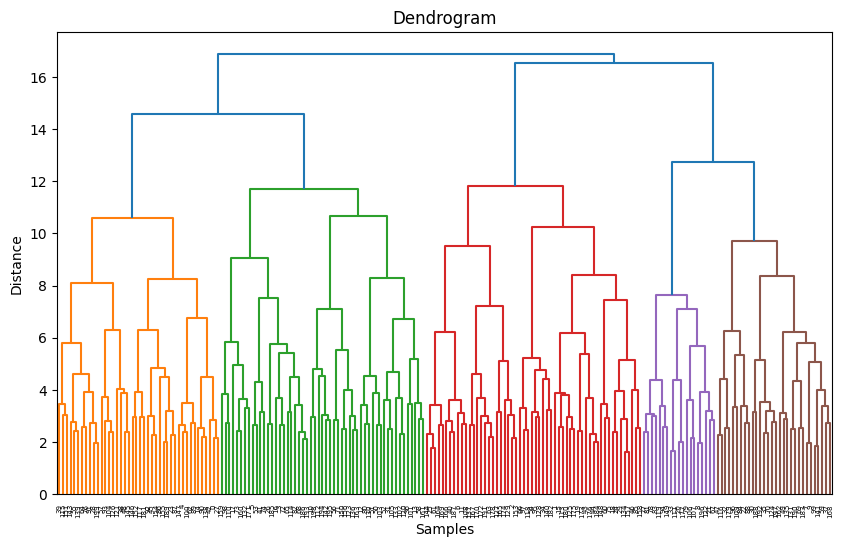

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['Delivery_Status']))

# Elbow Method
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Elbow Method')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()
# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=0)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=df['KMeans_Cluster'], palette='Set2')
plt.title("KMeans Clustering")
plt.show()
# Hierarchical Clustering
plt.figure(figsize=(10, 6))
sch.dendrogram(sch.linkage(X_scaled, method='ward'))
plt.title("Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()

agg = AgglomerativeClustering(n_clusters=3)
df['Hierarchical_Cluster'] = agg.fit_predict(X_scaled)


In [23]:
X = df.drop(columns=['Delivery_Status', 'KMeans_Cluster', 'Hierarchical_Cluster'])
y = df['Delivery_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

# Evaluate
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


C:\Users\devma\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Neural Network Accuracy: 0.725
[[ 0 10]
 [ 1 29]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.74      0.97      0.84        30

    accuracy                           0.72        40
   macro avg       0.37      0.48      0.42        40
weighted avg       0.56      0.72      0.63        40



In [24]:
print("KMeans Cluster Counts:\n", df['KMeans_Cluster'].value_counts())
print("Hierarchical Cluster Counts:\n", df['Hierarchical_Cluster'].value_counts())

fast = df[df['Delivery_Status'] == 0]
delayed = df[df['Delivery_Status'] == 1]
print("Average Tip (Fast):", fast['Tip_Amount'].mean())
print("Average Tip (Delayed):", delayed['Tip_Amount'].mean())


KMeans Cluster Counts:
 KMeans_Cluster
1    75
2    64
0    61
Name: count, dtype: int64
Hierarchical Cluster Counts:
 Hierarchical_Cluster
0    95
2    56
1    49
Name: count, dtype: int64
Average Tip (Fast): 48.348571428571425
Average Tip (Delayed): 46.05463576158941
